# Data Science Interview Challange
By Kevin Cole

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import datetime
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Goals - Part 1
- Aggregate login counts based on 15-minute time intervals
- Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

In [2]:
# Reading JSON to pandas dataframe
logins = pd.read_json('logins.json')

In [3]:
logins

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [4]:
logins = logins.set_index('login_time')

In [5]:
logins['login_volume'] = 1

In [6]:
logins

,login_volume
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
...,...
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1


In [7]:
logins_15_minute = logins.resample('15T', label='left', closed='right').sum()
logins_15_minute

,login_volume
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


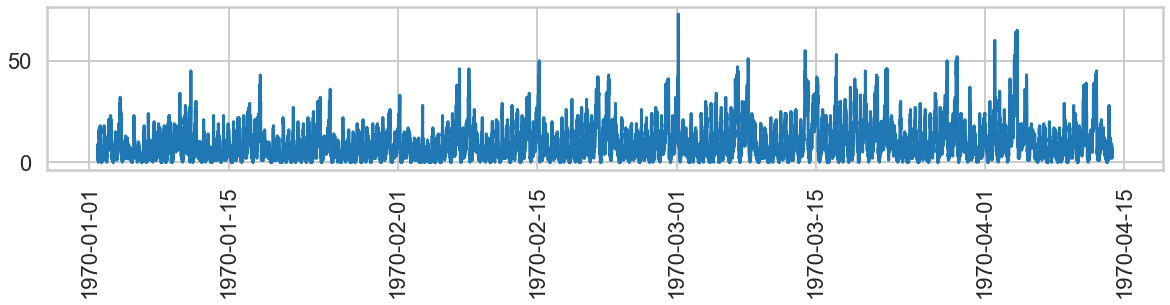

In [8]:
plt.figure(figsize=(20,3))
plt.plot(logins_15_minute.index, logins_15_minute.login_volume, )
plt.xticks(rotation=90)
plt.show()

This is rather chaotic. I'd like to view this data on a weekly basis. 

In [9]:
logins_weekly = logins.resample('W', label='left', closed='right').sum()
len(logins_weekly)

16

In [10]:
weeks = {
    0 : logins['1969-12-28':'1970-01-03'],
    1 : logins['1970-01-04':'1970-01-10'],
    2 : logins['1970-01-11':'1970-01-17'],
    3 : logins['1970-01-18':'1970-01-24'],
    4 : logins['1970-01-25':'1970-01-31'],
    5 : logins['1970-02-01':'1970-02-07'],
    6 : logins['1970-02-08':'1970-02-14'],
    7 : logins['1970-02-15':'1970-02-21'],
    8 : logins['1970-02-22':'1970-02-28'],
    9 : logins['1970-03-01':'1970-03-07'],
    10 : logins['1970-03-08':'1970-03-14'],
    11 : logins['1970-03-15':'1970-03-21'],
    12 : logins['1970-03-22':'1970-03-28'],
    13 : logins['1970-03-29':'1970-04-04'],
    14 : logins['1970-04-05':'1970-04-11'],
    15 : logins['1970-04-12':'1970-04-19']
}

In [11]:
week=0
agg_15_min = weeks[week].resample('15T', label='left', closed='right').sum()
agg_15_min

,login_volume
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-01-03 22:45:00,17
1970-01-03 23:00:00,13
1970-01-03 23:15:00,17


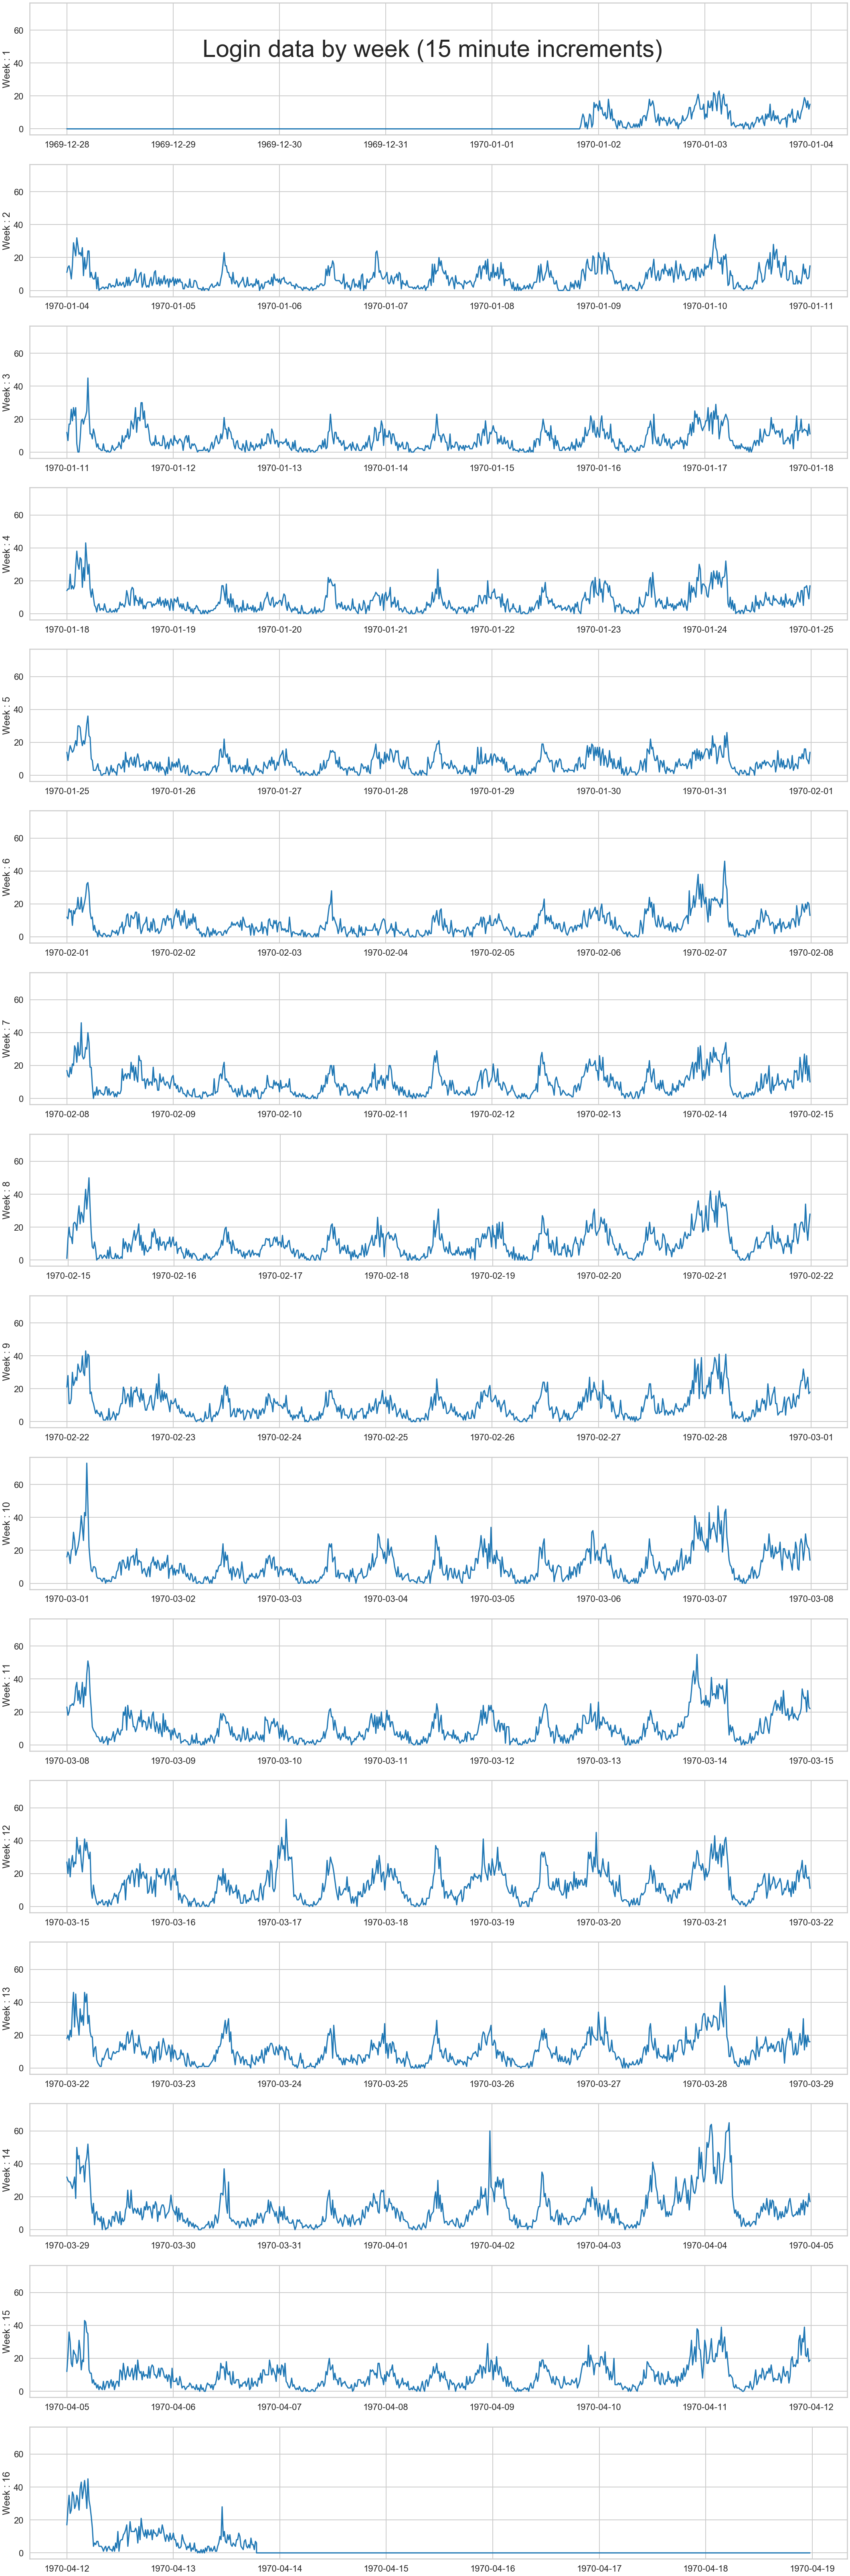

In [12]:
fig, axs = plt.subplots(16, 1, figsize=(30, 90), sharey=True)

fig.tight_layout(pad=3.0)

for week in range(16):
    # Looping each week -- Each week gets its own plot
    
    # Aggregating data on a 15-minute interval
    agg_15_min = weeks[week].resample('15T', label='left', closed='right').sum()
    
    # Padding data accounting for first and last weeks not containing a full week of data
    if len(agg_15_min) < 672:
        # 672 is the number of 15 minute increments in a week
        
        if week==0:
            #First week padding at start
            
            # Finding number of entries to be added
            buffer_count = 672 - len(agg_15_min)
            
            # Backing up from first datetime in data
            date_list = [agg_15_min.index[0] - datetime.timedelta(minutes=15*(x+1)) for x in range(buffer_count)]
            
            # Creating dataframe and appending to data, and sorting. 
            added_aggs = pd.DataFrame(0, index=sorted(date_list), columns=['login_volume'])
            added_aggs.index.name = 'login_time'
            agg_15_min = agg_15_min.append(added_aggs)
            agg_15_min = agg_15_min.sort_index()
            
        if week == 15:
            # Last week hard coded at 16 weeks
            
            # Finding number of entries to be added
            buffer_count = 672 - len(agg_15_min)
            
            # Incrementing up from last datetime in data
            date_list = [agg_15_min.index[-1] + datetime.timedelta(minutes=15*(x)) for x in range(buffer_count)]
            
            # Creating dataframe and appending to data, and sorting. 
            added_aggs = pd.DataFrame(0, index=sorted(date_list), columns=['login_volume'])
            added_aggs.index.name = 'login_time'
            agg_15_min = agg_15_min.append(added_aggs)
            agg_15_min = agg_15_min.sort_index()
    
    
    axs[week].plot(agg_15_min)
    axs[week].set_ylabel('Week : ' + str(week+1))
    
fig.suptitle("Login data by week (15 minute increments)", fontsize=60)    
plt.show()
    

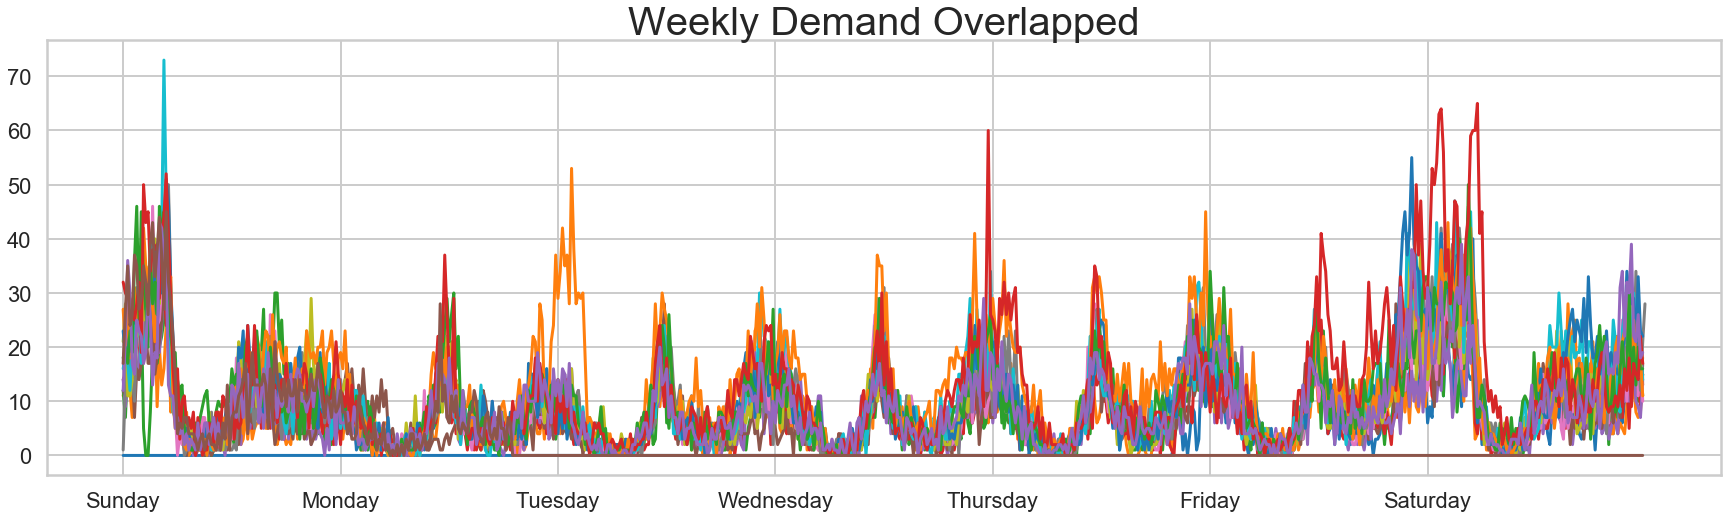

In [13]:

plt.figure(figsize=(30, 8)) # Width, Length
plt.title('Weekly Demand Overlapped', fontsize=40)

for week in range(16):
    # Looping each week -- Each week gets its own plot
    
    # Aggregating data on a 15-minute interval
    agg_15_min = weeks[week].resample('15T', label='left', closed='right').sum()
    
    # Padding data accounting for first and last weeks not containing a full week of data
    if len(agg_15_min) < 672:
        # 672 is the number of 15 minute increments in a week
        
        if week==0:
            #First week padding at start
            
            # Finding number of entries to be added
            buffer_count = 672 - len(agg_15_min)
            
            # Backing up from first datetime in data
            date_list = [agg_15_min.index[0] - datetime.timedelta(minutes=15*(x+1)) for x in range(buffer_count)]
            
            # Creating dataframe and appending to data, and sorting. 
            added_aggs = pd.DataFrame(0, index=sorted(date_list), columns=['login_volume'])
            added_aggs.index.name = 'login_time'
            agg_15_min = agg_15_min.append(added_aggs)
            agg_15_min = agg_15_min.sort_index()
            
        if week == 15:
            # Last week hard coded at 16 weeks
            
            # Finding number of entries to be added
            buffer_count = 672 - len(agg_15_min)
            
            # Incrementing up from last datetime in data
            date_list = [agg_15_min.index[-1] + datetime.timedelta(minutes=15*(x)) for x in range(buffer_count)]
            
            # Creating dataframe and appending to data, and sorting. 
            added_aggs = pd.DataFrame(0, index=sorted(date_list), columns=['login_volume'])
            added_aggs.index.name = 'login_time'
            agg_15_min = agg_15_min.append(added_aggs)
            agg_15_min = agg_15_min.sort_index()
    
    
    plt.plot(range(len(agg_15_min)), agg_15_min.login_volume)

plt.xticks(list(np.arange(0,672,96)), labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()
    

# Part 1 - Conclusion 

High volume login times appear to be a few hours centered around midnight each night, particularly on Friday and Saturday nights. Also notable that smaller peaks happen around noon each day. Data for the first and last weeks is not complete. 

# Part 2 - Scenario

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

# Part 2 - Goals
1. Determine key measure of success of this experiment in encouraging driver partners to serve both cities, and why?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Provide details on implementation, statistical tests, and interpretation of results for reccomendations

# Part 2 - Response

Measures of success for this experiment would include:

- Total toll reimbursements. The more tolls a driver is getting reimbursed the more times he is changing citites. 
- Percentage of driver toll revenue to total toll revenue. The amount of toll revenue relative to the total tolls collected as a percent should increase if drivers are operating in both citites. Both revenue from drivers tolls and total tolls collected would increase if drivers started operating in both cities, bringing the ratio upwards. 
- Trip counts: Volume of trips across the bridge for drivers both before and after the change. 
- Driver income per hour. Even if drivers begin crossing the bridge more, they will not continute to do so if it costs them money. Driver income at a minumum must stay equal. A decrease in driver income per hour would cause no change in the status quo as drivers would return to their original driving habbits. 

Experiment details would include
- Measuring data both before and after experiment.
- Data must be tagged with day of the week so comparisons can be made due to differences in the circadian rythms of the cities.
- On weekdays there may not be much bridge traffic. Even if a driver changes city, they are likely only doing that once a shift to get to the other city, and once on the way home. 
- On weekends, drivers are likely to stay local if they can get local rides, but may change citites back and forth due to demand in both cities.
- Hypothesis testing would occur to see if the differences in our measures of success were different in a statistically significant way in the before/after sets. Subsetting the data by week/weekend could also give insights into when in the week the toll reimbursment is more likely to change driver behavior. 
- Recommendations would be made based on p-values of the significance detected in each subset (week/weekend) 

# Part 3

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

# Task #1 - Exploritory Analysis and Cleaning

In [14]:
# Read in the data

file = open('ultimate_data_challenge.json', 'r')
riders = pd.DataFrame(json.load(file))
file.close()

riders

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [15]:
pd.to_datetime(riders.signup_date).sort_values()

4674    2014-01-01
7672    2014-01-01
1431    2014-01-01
15387   2014-01-01
17482   2014-01-01
           ...    
2013    2014-01-31
38728   2014-01-31
43123   2014-01-31
43127   2014-01-31
30220   2014-01-31
Name: signup_date, Length: 50000, dtype: datetime64[ns]

In [16]:
# Finding out what the last date in the last trip date column was
last_ride_date = pd.to_datetime(riders.last_trip_date)
last_ride_date.sort_values()

31425   2014-01-01
10729   2014-01-01
40336   2014-01-01
34828   2014-01-01
37295   2014-01-01
           ...    
45126   2014-07-01
38651   2014-07-01
14473   2014-07-01
22735   2014-07-01
45357   2014-07-01
Name: last_trip_date, Length: 50000, dtype: datetime64[ns]

The last date of ride data is 7/1. I am going to find all riders who took rides on or after 6/1 for retained definintion. 

In [17]:
# Finding what riders took rides in june
recent_riders = riders[last_ride_date > '2014-06-01']

In [18]:
# Percentage of riders retained
retained = len(recent_riders)/len(riders)
retained

0.3662

# 36.6% of riders were retained overall

In [19]:
# Adding a column to the dataframe to identify retained riders. 
riders['retained'] = False
riders['retained'].iloc[recent_riders.index] = True

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
recent_riders.trips_in_first_30_days.sort_values()

49995      0
18913      0
18897      0
18889      0
42333      0
        ... 
36917     56
48804     58
29070     63
3030      71
18514    125
Name: trips_in_first_30_days, Length: 18310, dtype: int64

In [21]:
riders[riders.retained == False].trips_in_first_30_days.sort_values()

1         0
24662     0
24668     0
24681     0
24690     0
         ..
25520    50
40271    51
36455    53
45489    56
99       73
Name: trips_in_first_30_days, Length: 31690, dtype: int64

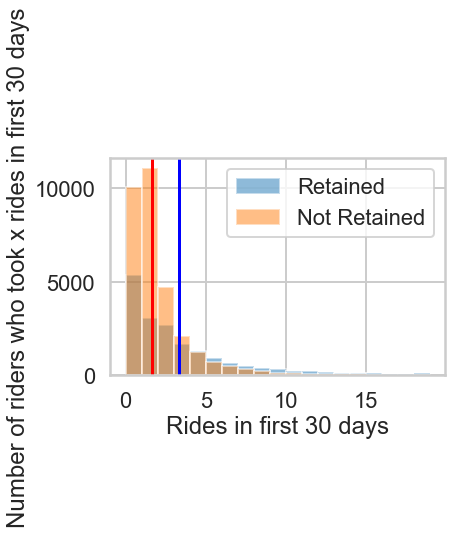

In [22]:
# Creating a histogram to illustrate number of rides in the first 30 days across two populations
plt.hist(recent_riders.trips_in_first_30_days, alpha=.5, label='Retained',
        bins = range(0,20,1))
plt.hist(riders[riders.retained == False].trips_in_first_30_days, alpha=.5, label='Not Retained',
        bins = range(0,20,1))

# Mean line for retained riders
plt.axvline(recent_riders.trips_in_first_30_days.mean(), color = 'b' )

# Mean line for other riders
plt.axvline(riders[riders.retained == False].trips_in_first_30_days.mean(), color = 'r' )

plt.legend()
plt.xlabel('Rides in first 30 days')
plt.ylabel('Number of riders who took x rides in first 30 days')

plt.show()

Seeing many non-retained riders with <5 rides in the first 30 days I'm curious as to that percentage. 

In [23]:
np.sum(riders[riders.retained == False].trips_in_first_30_days < 5)/len(riders)

0.5847

In [24]:
np.sum(riders[riders.retained == True].trips_in_first_30_days < 5)/len(riders)

0.2803

58% of riders who were not retained took less than 5 rides in the first 30 days as opposed to 28% of riders who were retained took less than 5 rides in the first 30 days. Rides in the first 30 days could be an indicator of rider retention. 

In [25]:
# Exploring retention of different phone platforms
iphone = riders[riders.phone == 'iPhone']
android = riders[riders.phone == 'Android']

In [26]:
np.sum(iphone.retained == True)/len(iphone)

0.44063385576311376

In [27]:
np.sum(android.retained == True)/len(android)

0.19584609239781653

Only 19% of android users are retained compared to 44% of iPhone Users! There is likely an issue with that application that is turning users off. 

In [28]:
premium_users = riders[riders.ultimate_black_user == True ]
non_premium_users = riders[riders.ultimate_black_user == False ]

In [29]:
np.sum(premium_users.retained == True)/len(premium_users)

0.49639333828365334

In [30]:
np.sum(non_premium_users.retained == True)/len(non_premium_users)

0.2873884286906826

In [31]:
list(riders.city.value_counts().index)

['Winterfell', 'Astapor', "King's Landing"]

In [32]:
retained = []
for city in list(riders.city.value_counts().index):
    retained.append(np.sum(riders[riders.city == city].retained)/len(riders[riders.city == city]))

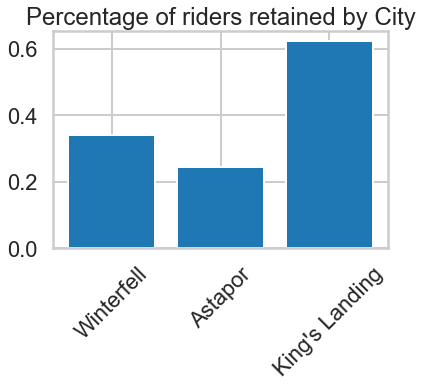

In [33]:
plt.bar(list(riders.city.value_counts().index),retained)
plt.xticks(rotation=45)
plt.title('Percentage of riders retained by City')
plt.show()

# Cleaning Data

I would like to remove textual elements from the dataset. This includes the city column and the phone column.

In [34]:
riders = pd.get_dummies(riders,prefix=['city','phone'], columns = ['city', 'phone'])

In [35]:
riders

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,True,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,False,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,False,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,True,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,False,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2014-01-25,5.0,1.00,2014-06-05,0.0,False,100.0,5.63,4.2,True,0,1,0,0,1
49996,1,2014-01-24,NaN,1.00,2014-01-25,0.0,False,0.0,0.00,4.0,False,1,0,0,0,1
49997,0,2014-01-31,5.0,1.00,2014-05-22,0.0,True,100.0,3.86,5.0,False,0,0,1,1,0
49998,2,2014-01-14,3.0,1.00,2014-01-15,0.0,False,100.0,4.58,3.5,False,1,0,0,0,1


In [36]:
# NaN values must be removed. For Average rating of driver, I am imputing a value of 5.0 since they are likely new drivers and the typical rating is 5.0 unless there are issues. 

riders.avg_rating_of_driver.loc[riders['avg_rating_of_driver'].isna() == True] = 5.0
riders.avg_rating_by_driver.loc[riders['avg_rating_by_driver'].isna() == True] = 5.0

The datetime strings will not be processed by a classifier. They must also be cleaned. Since the trip dates were used for determing retention truth data, I am going to remove them from the dataset to prevent them from becoming a driving predictor. 

Alternatively I could have changed the information to categorial information such as day of the week or hour of the day. 

In [37]:
riders = riders.drop(['signup_date','last_trip_date'], axis=1)

# Task 1 conclusions

- 36.6% of riders were retained overall
- Andriod users may have been turned off by the experience. Only 19% of users retained as opposed to 44% of iPhone users
- Ultimate Black users are retained at a 50% rate as opposed to only 29% of users who didn't use the service. 
- The users of kings landing were highly retained compared to those of Winterfell and Astapor.

# Task 2 

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

Approach: Retention is a categorical variable. Riders are either retained or they are not. This supervised learning problem requires a classification algorithm. I will begin with K-Nearest Neighbors

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [39]:
# Creating Arrays for features and targert
y = riders['retained'].values
X = riders.drop('retained', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, stratify=y)

In [40]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [41]:
print(knn.score(X_test, y_test))

0.7532


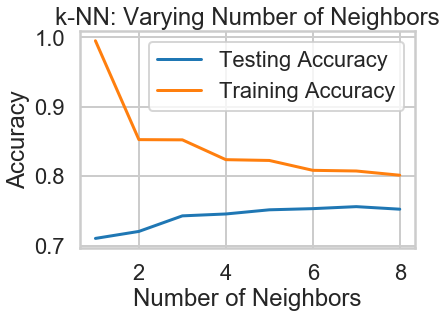

In [42]:
# Exploring different values of K-neighbors

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


In [43]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [44]:
n_feats = X_test.shape[1]

column_names = list(riders.columns)
column_names.remove('retained')

print('Feature  Accuracy')
for i in range(n_feats):
    X = X_test[:, i].reshape(-1,1)
    scores = cross_val_score(knn, X, y_test, cv=3)
    print(f'{list(column_names)[i]}        {scores.mean():g}')

Feature  Accuracy
trips_in_first_30_days        0.632483
avg_rating_of_driver        0.663521
avg_surge        0.701601
surge_pct        0.71456
ultimate_black_user        0.629359
weekday_pct        0.7228
avg_dist        0.60376
avg_rating_by_driver        0.68688
city_Astapor        0.541754
city_King's Landing        0.667917
city_Winterfell        0.557917
phone_Android        0.611682
phone_iPhone        0.612642


For this model, the most important features are Surge Percent, Weekday Percent, Average Surge and Average rating by driver. 